In [1]:
import sys,os,re,csv
from os.path import join
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import itertools
import lmfit

from astropy.convolution import Gaussian2DKernel
from astropy.visualization import MinMaxInterval,SqrtStretch,AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm

os.environ['MorphSED_DATA_PATH']='/home/yuanze/MorphSED'
sys.path.append('/home/yuanze/MorphSED')
from morphsed import Galaxy, AGN, sed_to_obse, image, coordinates_transfer
import morphsed.emission_lines as EL
from morphsed.profiles import reshape_img




Warning while initializing libprofit: Importing fftw wisdom from /home/yuanze/.profit/fftw_cache/unthreaded-wisdom_FFTW 3.3.4 wrappers to Intel MKL failed: 0


In [2]:

WFC3_IR=('F105W','F110W','F125W','F814W')
WFC3_UVIS=('F438W','F475W','F547M','F555W','F606W')
subband={
    "I":WFC3_IR,
    "B":WFC3_UVIS
}

pixsize={
    "B":0.04,
    "I":0.13
}
psfpixsize={
    "B":0.03,
    "I":0.06
}

##-------------------Source definition---------------------##
targname='I Zw 1'
targNum="1"

##-------------------Source properties---------------------##
ra=13.3955833333
dec=12.6933888889
z = 0.061
ebv = 0.0550
Av=0.1705
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1./(4*np.pi*dis**2)
cutsize = 15. ##cut regime: a 30*30 arcsec box
spec_aperturesize = 2.


##-------------------Source data file----------------------##
datapath='/data/xray/hst/s{0}'.format(targNum)
#psfpath='/Users/ding/Desktop/AGN/HSTpsf'
flist=os.listdir(datapath)
psfpath="/home/yuanze/HSTpsf"
hdulist=[flist[i] for i in range(len(flist)) if re.findall(".*drz.fits",flist[i]) != []]
images = []
filt=[]
instru=[]
tim=[]
gain=[]
eps_to_phyflux=[]
for i,data in enumerate(hdulist):
    print("Reading ",data," at ",datapath)
    hdu=fits.open(join(datapath,data))
    header = hdu[0].header
    
    tim.append(header['EXPTIME'])
    instru.append(header['INSTRUME'])
    filt.append(header['FILTER'])
    eps_to_phyflux.append(header['PHOTFLAM'])
    gain.append(np.mean((header['ATODGNA'],header['ATODGNB'],header['ATODGNC'],header['ATODGND'])))
    
    Magzp_ST={
    'WFC3':21.10,
    }
    if filt[-1] in WFC3_IR:
        cpixscale=(pixsize['I'],pixsize['I'])
    elif filt[-1] in WFC3_UVIS:
        cpixscale=(pixsize['B'],pixsize['B'])
    im=image(filename=join(datapath,data),hdu=1,zero_point=Magzp_ST[instru[-1]],pixel_scales=cpixscale)
    imcut=im.img_cut(ra,dec,cutsize,gain=float(gain[-1]),extime=1.)
    ###-------------Reading PSF---------------##
    if filt[-1] in WFC3_IR:
        im.read_PSF(join(psfpath,'I_ori/psf_{0}.fit'.format(filt[-1])))
        print("Reading PSF file at ",join(psfpath,'I_ori/psf_{0}.fit'.format(filt[-1])))
    elif filt[-1] in WFC3_UVIS:
        im.read_PSF(join(psfpath,'B_ori/psf_{0}.fit'.format(filt[-1])))
        print("Reading PSF file at ",join(psfpath,'I_ori/psf_{0}.fit'.format(filt[-1])))
    images.append(im)

    print ('-----------------------------')
    print ('Target: {0}'.format(targname))
    print ('Target Number: {0}'.format(targNum))
    print ('Instrument: {0}'.format(instru[-1]))
    print ('Filter: {0}'.format(filt[-1]))
    print ('Exposure: {0} s'.format(tim[-1]))
    
    






#for loop in range(5):
    #phys_to_counts_rate[loop] = phys_to_image[Band[loop]]*C_unit
ny,nx = imcut.shape
xaxis = np.arange(nx)
yaxis = np.arange(ny)
xmesh, ymesh = np.meshgrid(xaxis, yaxis)
xcen, ycen = coordinates_transfer(0.,0.,im.coordinates_transfer_para)
r = np.sqrt( (xmesh+0.5 - xcen)**2. + (ymesh+0.5 - ycen)**2.)
aperture_mask = r < (spec_aperturesize/im.pixel_scales[0].value)

Reading  iby807030_drz.fits  at  /data/xray/hst/s1
Calculated pixel difference by varying 1-arcsec RA: (X, pix) -4.544374496518008  (Y, pix) -6.100050833347608
Calculated pixel difference by varying 1-arcsec DEC: (X, pix) -6.253020523060184  (Y, pix) 4.65802207834167
Reading PSF file at  /home/yuanze/HSTpsf/I_ori/psf_F105W.fit
-----------------------------
Target: I Zw 1
Target Number: 1
Instrument: WFC3
Filter: F105W
Exposure: 147.018556 s
Reading  iby807020_drz.fits  at  /data/xray/hst/s1
Calculated pixel difference by varying 1-arcsec RA: (X, pix) -14.710224628993444  (Y, pix) -19.745816148809855
Calculated pixel difference by varying 1-arcsec DEC: (X, pix) -20.240977719613714  (Y, pix) 15.07810388615071
Reading PSF file at  /home/yuanze/HSTpsf/I_ori/psf_F438W.fit
-----------------------------
Target: I Zw 1
Target Number: 1
Instrument: WFC3
Filter: F438W
Exposure: 300.0 s


In [5]:
trig=0.04*np.array([14.710224628993444,19.745816148809855])
trig2=0.13*np.array([4.544374496518008,6.100050833347608])
print(np.sqrt(np.sum(trig**2)))
print(np.sqrt(np.sum(trig2**2)))

0.984916616992968
0.9888716395493785


In [6]:
#plot_image(images[0].PSF)

NameError: name 'plot_image' is not defined

In [3]:
import dense1 as de

fdata=np.array(np.around(np.nan_to_num(imcuts[0].data*np.array(tim[0]),nan=0,)),dtype=int)
#fdata.dtype=np.int64
fdata[(fdata < 0)]=0
model = de.build_density_estimator(fdata.shape)
#print(fdata[(fdata < 0)])
print(fdata.shape)
#samples, _ = de.fit(model, fdata, n_max_iterations=5)
#post_density_mean = np.mean(samples, axis=0)
#post_density_std = np.std(samples, axis=0)
im_kw = {"vmin": fdata.min(), "vmax": fdata.max(),'stretch':'log'}
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
im = axs.flat[0].imshow(fdata, **im_kw)
axs.flat[0].set_title("data")
im = axs.flat[1].imshow(fdata, **im_kw)
axs.flat[1].set_title("Data")
#im = axs.flat[2].imshow(post_density_mean, **im_kw)
axs.flat[2].set_title("Posterior Mean")
#im = axs.flat[3].imshow(post_density_std, **im_kw)
axs.flat[3].set_title("Posterior Std")
fig.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.75)
fig.savefig("synthetic_HST.png")
#plt.close()

NameError: name 'imcuts' is not defined

# 1. Sersic + PSF fit

### 1.1 Define the parameters

In [10]:
par_total = lmfit.Parameters()
par_total.add('logM', value=10., min=8., max=13.)
sesicparam = ['x', 'y', 'Re', 'n', 'ang', 'axrat']
par_total.add('BoT', value=0.3, min=0.05, max=0.95)
par_total.add('sersic1_x', value=0, min=-4., max=4)
par_total.add('sersic1_y', value=0, min=-4., max=4)
par_total.add('sersic1_Re', value=0.5, min=0.1, max=15)
par_total.add('sersic1_n', value=3., min=1., max=6.)
par_total.add('sersic1_ang', value=0., min=-90., max=90.,vary=False)
par_total.add('sersic1_axrat', value=1, min=0.2, max=1.,vary=False)
par_total.add('sersic1_f_cont', value=0.5, min=0., max=1.)
par_total.add('sersic1_age', value=5., min=0.1, max=13.)
par_total.add('sersic1_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic1_Av', value=0.7, min =0.3, max=5.1)
par_total.add('sersic2_x', expr='1.*sersic1_x')
par_total.add('sersic2_y', expr='1.*sersic1_y')
par_total.add('sersic2_Re', value=10., min=3., max=45.)
par_total.add('sersic2_n', value=1., vary=False)
par_total.add('sersic2_ang', value=-20., min=-90., max=90.)
par_total.add('sersic2_axrat', value=0.8, min=0.2, max=1.)
par_total.add('sersic2_f_cont', value=0.5, min=0., max=1.)
#par_total.add('sersic2_f_cont_k', value=0.0, min=-1, max=1)
#par_total.add('sersic2_f_cont_b', value=0.5, min=0., max=1.)

par_total.add('sersic2_age', value=1., min=0.1, max=13.)
par_total.add('sersic2_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic2_Av', value=0.7, min =0.3, max=5.1)
par_total.add('agn_x', expr='1.*sersic1_x')
par_total.add('agn_y', expr='1.*sersic1_y')
par_total.add('agn_logM', value=6.9, min=5., max=10.,vary=False)
par_total.add('agn_logLedd', value=2.58, min=-4, max=2.)
par_total.add('agn_spin', value=0.99, min=0., max=0.99,vary=False)
par_total.add('agn_Av', value=0., min =0., max=3.1,vary=False)
for loop,ins in enumerate(instru):
    sm = images[loop].sky_median
    par_total.add('sky_{0}_{1}'.format(ins,filt[loop]), value=sm, min =sm-0.5, max=sm+0.5,vary=True)

par_total.add('N_agn', value=1., min =0.1, max=10.,vary=False)
par_total.add('N_gal', value=1., min =0.1, max=10.)
"""
Myagn = AGN(logM_BH=par_total['agn_logM'].value,logLedd= par_total['agn_logLedd'].value,
                    astar=par_total['agn_spin'].value,Av =par_total['agn_Av'].value, z=z, ebv_G=ebv)

lines_broad = [EL.Ha]
lines_narrow = [EL.OII,EL.NeIII,EL.Hb,EL.Ha]
par_BLR,par_NLR = Myagn.set_full_model(spec,lines_broad,lines_narrow,nbroad=1)
par_total = par_total.update(par_BLR)
par_total = par_total.update(par_NLR)
par_total['FeIIA_uv'].set(vary=False)
par_total['FeIIA_op'].set(vary=False)
par_total['FeIIfwhm'].set(vary=False)
par_total['FeIIdcen'].set(vary=False)
par_total['BaCcf'].set(vary=False)
par_total['BaCdcen'].set(vary=False)
par_total['BaCfwhm'].set(vary=False)
par_total['Hab1amplitude'].set(vary=False)
par_total['Hab1center'].set(vary=False)
par_total['Hab1sigma'].set(vary=False)
"""

"\nMyagn = AGN(logM_BH=par_total['agn_logM'].value,logLedd= par_total['agn_logLedd'].value,\n                    astar=par_total['agn_spin'].value,Av =par_total['agn_Av'].value, z=z, ebv_G=ebv)\n\nlines_broad = [EL.Ha]\nlines_narrow = [EL.OII,EL.NeIII,EL.Hb,EL.Ha]\npar_BLR,par_NLR = Myagn.set_full_model(spec,lines_broad,lines_narrow,nbroad=1)\npar_total = par_total.update(par_BLR)\npar_total = par_total.update(par_NLR)\npar_total['FeIIA_uv'].set(vary=False)\npar_total['FeIIA_op'].set(vary=False)\npar_total['FeIIfwhm'].set(vary=False)\npar_total['FeIIdcen'].set(vary=False)\npar_total['BaCcf'].set(vary=False)\npar_total['BaCdcen'].set(vary=False)\npar_total['BaCfwhm'].set(vary=False)\npar_total['Hab1amplitude'].set(vary=False)\npar_total['Hab1center'].set(vary=False)\npar_total['Hab1sigma'].set(vary=False)\n"

### 1.2 Calculate the multi-band residual

In [11]:
def residualcon(parc):
    strucure_para1 = {'xcen': parc['sersic1_x'].value, 'ycen': parc['sersic1_y'].value,
                     'frac': 100.*parc['BoT'], 're': parc['sersic1_Re'].value, 'nser': parc['sersic1_n'].value,
                     'ang': parc['sersic1_ang'].value, 'axrat': parc['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
    age1 = {'type': "const", 'paradic':{'value': parc['sersic1_age'].value}}
    Z1 = {'type': "const", 'paradic':{'value':  parc['sersic1_Z'].value}}
    f_cont1 = {'type': "const", 'paradic':{'value': parc['sersic1_f_cont'].value}}
    Av1 = {'type': "const", 'paradic':{'value': parc['sersic1_Av'].value}}
    strucure_para2 = {'xcen': parc['sersic2_x'].value, 'ycen': parc['sersic2_y'].value,
                     'frac': 100.*(1.-parc['BoT']), 're': parc['sersic2_Re'].value, 'nser': parc['sersic2_n'].value,
                     'ang': parc['sersic2_ang'].value, 'axrat': parc['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
    age2 = {'type': "const", 'paradic':{'value': parc['sersic2_age'].value}}
    f_cont2 = {'type': "const", 'paradic':{'value': parc['sersic2_f_cont'].value}}
    Z2 = {'type': "const", 'paradic':{'value':  parc['sersic2_Z'].value}}
    #f_cont2 = {'type': "linear", 'paradic':{'k': parc['sersic2_f_cont_k'].value,'b': parc['sersic2_f_cont_b'].value}}
    Av2 = {'type': "const", 'paradic':{'value': parc['sersic2_Av'].value}}
    residual_image=[]
    for loop,cinstru in enumerate(instru):
        cfilt = filt[loop]
        im=images[loop]
        ny,nx=im.cut_image.shape
        Mygalaxy = Galaxy(mass = 10**parc['logM'].value, z=z, ebv_G=ebv)
        Mygalaxy.add_subC('sersic',strucure_para1,age1,Z1,f_cont1,Av1)
        Mygalaxy.add_subC('sersic',strucure_para2,age2,Z2,f_cont2,Av2)
        if loop == len(instru)-1:
            totalmass,apertures=Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im.coordinates_transfer_para,aperturemask=aperture_mask)
        else:
            totalmass,apertures = Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im.coordinates_transfer_para)
        image = Mygalaxy.generate_image('{0}_{1}'.format(cinstru,cfilt).lower(),im.PSF)
        #image = Mygalaxy.generate_image('desi_n_z',im.PSF)
        #image += Myagn.generate_image([ny,nx],'HST_{0}_{1}'.format(cinstru,cfilt),psfs[loop],agnlocation)
        image *= (C_unit/eps_to_phyflux[loop])#phys_to_counts_rate
        image += np.ones_like(image)*parc['sky_{0}_{1}'.format(cinstru,cfilt)].value
        residual_image.append((im.cut_image-image)/im.cut_sigma_image)
    residu_flat = residual_image[0].ravel()
    for loop in range(len(instru)-1):
        residu_flat=np.append(residu_flat,residual_image[loop+1].ravel())
    del (Mygalaxy)
    return residu_flat
    

# Go fitting!

In [12]:
fitresult = lmfit.minimize(residualcon,par_total,nan_policy='omit' )

wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w
wfc3_f438w
wfc3_f105w

# Summarize and plot the result

In [15]:
par_total = fitresult.params
bestpar = par_total.valuesdict()
filepath="/home/yuanze/my_work"
w = csv.writer(open(filepath+"/bestpar.csv", "w"))
for key, val in bestpar.items():
    w.writerow([key, val])
w = csv.writer(open(filepath+"/fake.csv", "w"))

strucure_para1 = {'xcen': par_total['sersic1_x'].value, 'ycen': par_total['sersic1_y'].value,
                 'frac': 100.*par_total['BoT'], 're': par_total['sersic1_Re'].value, 'nser': par_total['sersic1_n'].value,
                 'ang': par_total['sersic1_ang'].value, 'axrat': par_total['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
age1 = {'type': "const", 'paradic':{'value': par_total['sersic1_age'].value}}
Z1 = {'type': "const", 'paradic':{'value':  par_total['sersic1_Z'].value}}
f_cont1 = {'type': "const", 'paradic':{'value': par_total['sersic1_f_cont'].value}}
Av1 = {'type': "const", 'paradic':{'value': par_total['sersic1_Av'].value}}
strucure_para2 = {'xcen': par_total['sersic2_x'].value, 'ycen': par_total['sersic2_y'].value,
                 'frac': 100.*(1.-par_total['BoT']), 're': par_total['sersic2_Re'].value, 'nser': par_total['sersic2_n'].value,
                 'ang': par_total['sersic2_ang'].value, 'axrat': par_total['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
age2 = {'type': "const", 'paradic':{'value': par_total['sersic2_age'].value}}
Z2 = {'type': "const", 'paradic':{'value':  par_total['sersic2_Z'].value}}
f_cont2 = {'type': "const", 'paradic':{'value': par_total['sersic2_f_cont'].value}}
Av2 = {'type': "const", 'paradic':{'value': par_total['sersic2_Av'].value}}
imagecuts = []
model_image = []
residual_image = []
for loop,cinstru in enumerate(instru):
    #print (loop)
    cfilt=filt[loop]
    im = images[loop]
    ny,nx = im.cut_image.shape
    Mygalaxy = Galaxy(mass = 10**par_total['logM'].value, z=z, ebv_G=ebv)
    Mygalaxy.add_subC('sersic',strucure_para1,age1,Z1,f_cont1,Av1)
    Mygalaxy.add_subC('sersic',strucure_para2,age2,Z2,f_cont2,Av2)
    if loop == len(instru)-1:
        totalmass,apertures = Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im.coordinates_transfer_para,aperturemask=aperture_mask)
    else:
        totalmass,apertures = Mygalaxy.generate_mass_map((ny,nx),np.array(im.PSF),transpar=im.coordinates_transfer_para)
    imm = Mygalaxy.generate_image("{0}_{1}".format(cinstru,cfilt).lower(),im.PSF)
    imm *= (C_unit/eps_to_phyflux[loop])
    imm += np.ones_like(imm)*par_total['sky_{0}_{1}'.format(cinstru,cfilt)].value
    imagecuts.append(im.cut_image)
    residual_image.append(im.cut_image-imm)
    model_image.append(imm)
    
    

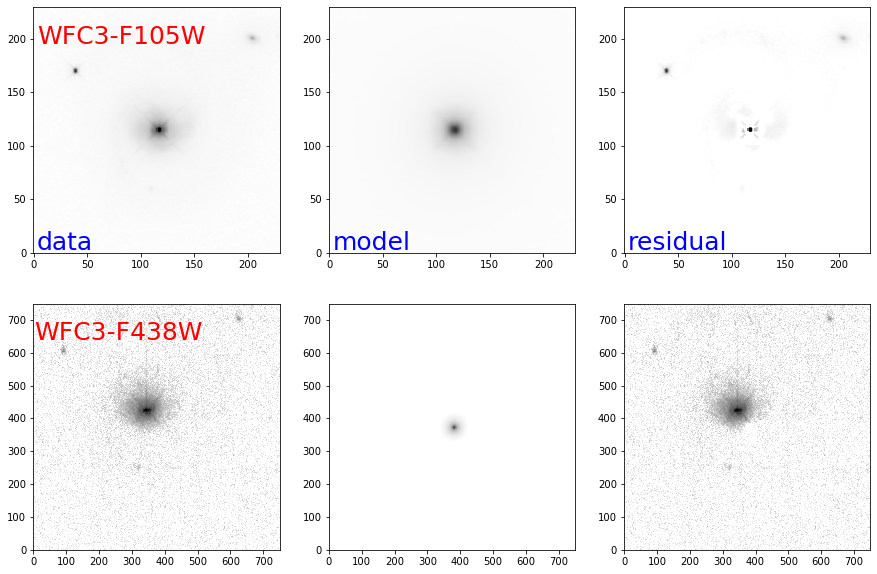

In [16]:

data_all = [imagecuts,model_image,residual_image]
shape=[ny,nx]
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows),squeeze=True)
ax = ax.ravel()
fignumber=15
for i in range(nrows):
    sky_mean, sky_median, sky_std = sigma_clipped_stats(data_all[0][i], sigma=3.0, maxiters=5)
    norm = simple_norm([0.5*sky_std, 3*np.max(data_all[1][i])], 'log', percent=100)
    for j in range(ncols):
        ax[3*i+j].imshow(data_all[j][i], cmap='Greys', origin='lower', norm=norm,
                           interpolation='nearest')
    ny,nx = data_all[0][i].shape
    ax[3*i+0].text(3,0.85*ny, "{0}-{1}".format(instru[i],filt[i]), size = 25, color = 'r', weight = "light" )
ax[0].text(3,3, "data", size = 25, color = 'b', weight = "light" )
ax[1].text(3,3, "model", size = 25, color = 'b', weight = "light" )
ax[2].text(3,3, "residual", size = 25, color = 'b', weight = "light" )
plt.savefig(filepath+'/multifit_withspec.png',dpi=300,bbox_inches='tight')
plt.show()



In [ ]:
def multi_model(parc):
    Mygalaxy = Galaxy(mass = 10**parc['logM'].value, z=z, ebv_G=ebv)
    Myagn = AGN(logM_BH=parc['agn_logM'].value,logLedd= parc['agn_logLedd'].value,
                astar=parc['agn_spin'].value,Av =parc['agn_Av'].value, z=z, ebv_G=ebv)
    strucure_para = {'xcen': parc['sersic1_x'].value, 'ycen': parc['sersic1_y'].value,
                     'frac': 100., 're': parc['sersic1_Re'].value, 'nser': parc['sersic1_n'].value, 
                     'ang': parc['sersic1_ang'].value, 'axrat': parc['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
    age = {'type': "const", 'paradic':{'value': parc['sersic1_age'].value}}
    Z = {'type': "const", 'paradic':{'value':  parc['sersic1_Z'].value}}
    f_cont = {'type': "const", 'paradic':{'value': parc['sersic1_f_cont'].value}}
    Av = {'type': "const", 'paradic':{'value': parc['sersic1_Av'].value}}
    Mygalaxy.add_subC('sersic',strucure_para,age,Z,f_cont,Av)
    totalmass = Mygalaxy.generate_mass_map((ny,nx),np.array(psfs[0]))
    agnlocation = {'xcen': parc['agn_x'].value, 'ycen': parc['agn_y'].value,}
    model_images=[]
    residual_images=[]
    for loop,cinstru in enumerate(instru):
        cfilt = filt[loop]
        image = Mygalaxy.generate_image('HST_{0}_{1}'.format(cinstru,cfilt),psfs[loop])
        #print (image.shape)
        #print (np.sum(image))
        AGNflux = Myagn.generate_image([ny,nx],'HST_{0}_{1}'.format(cinstru,cfilt),psfs[loop],agnlocation)
        image += AGNflux
        #print (np.max(AGNflux))
        #print (np.sum(AGNflux))
        image *= C_unit#phys_to_counts_rate[loop]
        image += np.ones_like(image)*parc['sky_{0}_{1}'.format(cinstru,cfilt)].value
        model_images.append(image)
        residual_images.append(images[loop]-image)
    del (Mygalaxy)
    del (Myagn)
    return model_images,residual_images
    

### 1.3 MCMC minimization

In [ ]:
fitresult = lmfit.minimize(residualcon,par_total,nan_policy='omit')
            #,method='ultranested',, nlive=160, maxiters=100, dlogz=0.02, workers=16)
            #,method='emcee',allrandom=False,nan_policy='omit',nwalkers=192,steps=2000,burn=1500,workers=48)
            #,method='nested',nan_policy='omit',sample_method='slice',dynamical=False, nlive=200, maxiters=100000, dlogz=0.02, workers=40)
    #            ,method='nested',nan_policy='omit',sample_method='rstagger',bound='multi',dynamical=True, nlive=150, maxiters=100000, dlogz=0.2, workers=4,
    #            dynesty_kwargs={'nlive_batch': 300,})

In [ ]:
par_total = fitresult.params
bestpar = par_total.valuesdict()
model_images,residual_images = multi_model(par_total)

In [ ]:
fitresult

In [ ]:
data_all = [images,model_images,residual_images]

In [ ]:
shape=[ny,nx]
nrows = 5
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25),squeeze=True)
ax = ax.ravel()
fignumber=15
for i in range(nrows):
    sky_mean, sky_median, sky_std = sigma_clipped_stats(images[i], sigma=3.0, maxiters=5)
    norm = simple_norm([0.5*sky_std, 3*np.max(data_all[1][i])], 'log', percent=100)
    for j in range(ncols):
        ax[3*i+j].imshow(data_all[j][i], cmap='Greys', origin='lower', norm=norm,
                           interpolation='nearest')
    ax[3*i+0].text(3,80, "{0}-band".format(Band[i]), size = 25, color = 'k', weight = "light" )
ax[0].text(3,3, "data", size = 25, color = 'k', weight = "light" )
ax[1].text(3,3, "model", size = 25, color = 'k', weight = "light" )
ax[2].text(3,3, "residual", size = 25, color = 'k', weight = "light" )
plt.savefig(filepath+'{0}_multifixc.png'.format(targname),dpi=200.,bbox_inches='tight')
plt.close()

In [ ]:
# g band
        show_ellipse(ax=ax0, data_isolist=r_g, psf_isolist=r1_g, sersic_isolist=r2_g, model_isolist=r0_g, band='g',
                     exptime=EXPTIME, ylabel=True, legend=True, xlabel=False, skyrms=skyrms_list[0], chi2nu=chi2nu[0],
                     name=name)
        norm1 = simple_norm([0.5*skyrms_list[0], 3*np.max(model_g)], 'log', percent=100)
        ax1.imshow(image_g-np.mean(sky_g), cmap='Greys', origin='lower', norm=norm1, extent=[-shape[0]*0.25/2, shape[0]*0.25/2, -shape[0]*0.25/2, shape[0]*0.25/2],
                           interpolation='nearest')
        ax1.text(0.42, 0.97, 'Data', verticalalignment='top',
            horizontalalignment='left', transform=ax1.transAxes,
             fontsize=42, bbox=dict(facecolor='white', alpha=0.7, edgecolor="none"))
        scalebar = ScaleBar(kpc_arcsec,
                            "kpc",
                            dimension=cgs,
                            color='black',
                            box_alpha=0.5,
                            font_properties={'size': 30},
                            location='lower left',
                            fixed_value=10,
                            scale_loc='bottom',
                            sep=10,
                            border_pad=0.6)
        ax1.add_artist(scalebar)
        ax2.imshow(model_g-np.mean(sky_g), cmap='Greys', origin='lower', norm=norm1, extent=[-shape[0]*0.25/2, shape[0]*0.25/2, -shape[0]*0.25/2, shape[0]*0.25/2],
                           interpolation='nearest')
        ax2.text(0.38, 0.97, 'Model', verticalalignment='top',
            horizontalalignment='left', transform=ax2.transAxes,
             fontsize=42, bbox=dict(facecolor='white', alpha=0.7, edgecolor="none"))
        ax3.imshow(image_g-psf_g-np.mean(sky_g), cmap='Greys', origin='lower', norm=norm1, extent=[-shape[0]*0.25/2, shape[0]*0.25/2, -shape[0]*0.25/2, shape[0]*0.25/2],
                           interpolation='nearest')
        ax3.text(0.235, 0.97, 'Data$-$Nucleus', verticalalignment='top',
            horizontalalignment='left', transform=ax3.transAxes,
             fontsize=42, bbox=dict(facecolor='white', alpha=0.7, edgecolor="none"))
        ax4.imshow(residual_g, cmap='Greys', origin='lower', norm=norm1, extent=[-shape[0]*0.25/2, shape[0]*0.25/2, -shape[0]*0.25/2, shape[0]*0.25/2],
                           interpolation='nearest')
        ax4.text(0.35, 0.97, 'Residual', verticalalignment='top',
            horizontalalignment='left', transform=ax4.transAxes,
             fontsize=42, bbox=dict(facecolor='white', alpha=0.7, edgecolor="none"))

In [ ]:
varnames=[]
pardict = par_total.valuesdict()
for el in pardict:
    if par_total[el].expr is not None:
        par_total[el].vary = False
    if par_total[el].vary:
        varnames.append(el)
print (varnames)


In [ ]:
print (len(varnames))

In [ ]:
#'''
targname = '164'
Band = ['g','r','i','z','y']
for band in Band:
    hdu = fits.open(filepath + '{0}_{1}.fits'.format(targname,band))
    data = hdu[0].data
    datacut = data[316:407,316:407]
    hdu0 = fits.PrimaryHDU(datacut.astype('float32'))
    hdulist = fits.HDUList([hdu0])
    hdulist.writeto(filepath + '{0}cut_{1}.fits'.format(targname,band),overwrite=True)
#''' 